In [1]:
import qiskit
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Key operators

In [23]:
def init_source_op(qc, q, source):
    """Construct the source state from all 0's state"""
    for qbit, sbit in zip(q, source):
        if sbit:
            qc.x(qbit)
            
def a_op(qc, q, source, inv=False):
    """Construct all equal superposition from initial (source) state"""
    for qbit, sbit in zip(q, source):
        qc.rx((-1)**(inv+sbit)*np.pi/2, qbit)

def mcz_op(qc, controls, target):
    """Multi-controlled-Z operator"""
    return qc.mcu1(np.pi, controls, target)
    
def ss_op(qc, q):
    """Reflection about initial (source) state"""
    # multi-controlled-Z
    qc.mcu1(np.pi, q[:-1], q[-1])
    
def st_op(qc, q, target, phase=np.pi):
    """Reflection about target state (t)"""
    # flip qubits corresponding to a zero target bit
    for qbit, tbit in zip(q, target):
        if not tbit:
            qc.x(qbit)
    # multi-controlled-Z
    qc.mcu1(phase, q[:-1], q[-1])
    # flip qubits corresponding to a zero target bit
    for qbit, tbit in zip(q, target):
        if not tbit:
            qc.x(qbit)

def grover_op(qc, q, source, weights=None):
    """Operator for one Grover iteration"""
    # number of qubits
    n = len(source)
    # add phase according to state value
    for i in range(2**n):
        state = [int(bit) for bit in reversed(bin(i)[2:].zfill(n))]
        weight = weights[i] if weights is not None else i/(2**n-1)
        if weight != 0:
            st_op(qc, q, state, phase=np.pi*weight)
    a_op(qc, q, source, inv=False)
    ss_op(qc, q)
    a_op(qc, q, source, inv=True)

In [13]:
n = 3
source = [0] * n

# quantum circuit
q = qiskit.QuantumRegister(n, name='q')
qc = qiskit.QuantumCircuit(q, name='qc')

# initialize
# construct source
init_source_op(qc, q, source)
# construct equal superposition
a_op(qc, q, source)

# add phase according to state value
for i in range(2**n):
    state = [int(bit) for bit in reversed(bin(i)[2:].zfill(n))]
    st_op(qc, q, state, phase=np.pi*i/(2**n-1))

qc.measure_all()

# qc.draw()

{'100': 509, '111': 496, '001': 504, '000': 520, '101': 485, '010': 525, '110': 560, '011': 497}


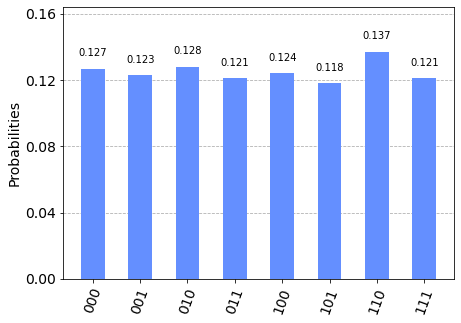

In [14]:
# qasm simulator
backend = qiskit.BasicAer.get_backend('qasm_simulator')
job = qiskit.execute(qc, backend, shots=4096)
results = job.result().get_counts()
print(results)
qiskit.visualization.plot_histogram(results)

In [102]:
# state vector simulator
backend = qiskit.BasicAer.get_backend('statevector_simulator')
qc.remove_final_measurements()
job = qiskit.execute(qc, backend)
np.angle(job.result().get_statevector())/np.pi

array([-1.80457737e-16,  1.42857143e-01,  2.85714286e-01,  4.28571429e-01,
        5.71428571e-01,  7.14285714e-01,  8.57142857e-01,  1.00000000e+00])

# Construct quantum circuit

In [15]:
# inputs
n = 5
source = [0] * n

# optimal iterations
niter = 2 # int(np.ceil(np.pi*np.sqrt(2**n)/4))
print("Optimal number of iterations = %s" % niter)

# quantum circuit
q = qiskit.QuantumRegister(n, name='q')
c = qiskit.ClassicalRegister(n, name='c')
qc = qiskit.QuantumCircuit(q, c, name='qc')

# initialize
# construct source
init_source_op(qc, q, source)
# construct equal superposition
a_op(qc, q, source)

# Grover iterations
for _ in range(niter):
    grover_op(qc, q, source)
    
# measurement
list(map(lambda x: qc.measure(*x), zip(q, c)))

print("------- operation counts (raw) -------")
for op, count in qc.count_ops().items():
    if op == 'measure':
        continue
    print("%s: %d" % (op, count))
    
print("------- operation counts (decomposed) -------")
for op, count in qc.decompose().count_ops().items():
    if op == 'measure':
        continue
    print("%s: %d" % (op, count))

# qc.draw()

Optimal number of iterations = 2
------- operation counts (raw) -------
x: 320
mcu1: 66
rx: 25
------- operation counts (decomposed) -------
cu1: 990
cx: 924
u3: 320
r: 25


# Qiskit simulation

{'11100': 66, '01001': 104, '00010': 115, '11110': 139, '00110': 33, '01110': 226, '00100': 47, '11010': 33, '11001': 45, '00000': 228, '11011': 52, '00101': 36, '10010': 192, '10100': 152, '10011': 180, '10101': 137, '00011': 60, '01100': 182, '01011': 168, '10110': 115, '01000': 63, '11111': 238, '01010': 139, '10000': 253, '10001': 205, '01101': 215, '01111': 213, '00111': 47, '00001': 170, '10111': 78, '11000': 53, '11101': 112}


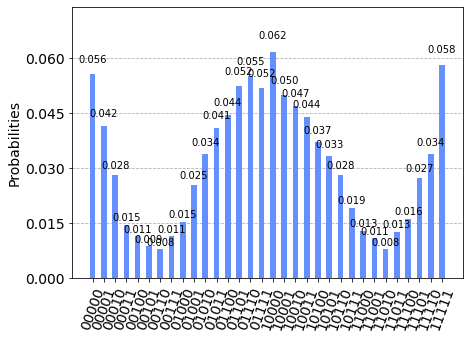

In [16]:
# qasm simulator
backend = qiskit.BasicAer.get_backend('qasm_simulator')
job = qiskit.execute(qc, backend, shots=4096)
results = job.result().get_counts()
print(results)
qiskit.visualization.plot_histogram(results)

In [112]:
# state vector simulator
backend = qiskit.BasicAer.get_backend('statevector_simulator')
qc.remove_final_measurements()
job = qiskit.execute(qc, backend)
np.angle(job.result().get_statevector())/np.pi

array([-0.28301751, -0.27038691, -0.2581619 , -0.24643996, -0.23535056,
       -0.22506955, -0.21584178, -0.20801807, -0.20211803, -0.19894173,
       -0.1997777 , -0.20681019, -0.2239457 , -0.25844474, -0.32315728,
       -0.43205815, -0.56794185, -0.67684272, -0.74155526, -0.7760543 ,
       -0.79318981, -0.8002223 , -0.80105827, -0.79788197, -0.79198193,
       -0.78415822, -0.77493045, -0.76464944, -0.75356004, -0.7418381 ,
       -0.72961309, -0.71698249])

In [6]:
backend = qiskit.BasicAer.get_backend('unitary_simulator')
qc.remove_final_measurements()
job = qiskit.execute(qc, backend)
job.result().get_unitary()

array([[ 9.61579519e-17+5.13584637e-03j,  1.50234296e-01+6.98567981e-16j,
         2.03319095e-01+4.52456188e-16j, ...,
        -7.10027482e-16+2.03319095e-01j, -4.04497209e-16+1.50234296e-01j,
         1.50234296e-01+4.70416702e-16j],
       [ 5.13584637e-03-3.80447155e-17j, -6.46745217e-16+2.03319095e-01j,
         5.63478490e-16-2.03319095e-01j, ...,
        -1.50234296e-01-4.46130573e-16j,  1.50234296e-01+5.39805641e-16j,
        -3.56143893e-16+2.03319095e-01j],
       [ 5.13584637e-03-7.25223446e-17j,  4.24481672e-16-1.50234296e-01j,
        -3.55092732e-16+1.50234296e-01j, ...,
         2.03319095e-01+6.75333012e-16j, -2.03319095e-01-3.90838362e-16j,
        -4.53288407e-16+2.03319095e-01j],
       ...,
       [ 3.55402697e-17+5.13584637e-03j, -2.03319095e-01-5.31044324e-16j,
         2.03319095e-01+4.26128696e-16j, ...,
        -3.92150767e-17+2.03319095e-01j,  3.83828570e-17-2.03319095e-01j,
         1.50234296e-01-7.57145538e-17j],
       [ 2.25082821e-17+5.13584637e-03j,  1.

# Analysis

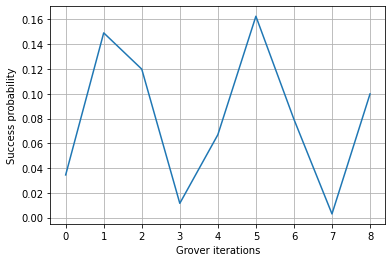

In [30]:
# success rate vs number of iterations

# inputs
target = [0, 1, 0, 1, 0]
n = len(target)
source = [0] * n

weights = [0] * 2**n
i_target = 0
for bit in target:
    i_target = (i_target << 1) | bit
weights[i_target] = 0.5
b_target = bin(i_target)[2:].zfill(n)

# simulation parameters
backend = qiskit.BasicAer.get_backend('qasm_simulator')
shots = 4096
niters = list(range(9))

# outputs
res = []

# iterate over number of Grover iterations
for r in niters:
    
    q = qiskit.QuantumRegister(n, name='q')
    c = qiskit.ClassicalRegister(n, name='c')
    qc = qiskit.QuantumCircuit(q, c, name='qc')
    
    # initialize
    # construct source
    init_source_op(qc, q, source)
    # construct equal superposition
    a_op(qc, q, source)
    
    # Grover iterations
    for _ in range(r):
        grover_op(qc, q, source, weights)

    # measure
    list(map(lambda x: qc.measure(*x), zip(q, c)))

    job = qiskit.execute(qc, backend, shots=shots)
    counts = job.result().get_counts().get(b_target, 0)
    res.append(counts)
    
# plot
plt.plot(niters, [c/shots for c in res])
plt.xlabel("Grover iterations")
plt.ylabel("Success probability")
plt.grid('on')